In [1]:
import os, tempfile
import logging

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        #sakakibara_inact_kin_100,
                                        #sakakibara_inact_kin_80,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

In [5]:
modelfile = 'models/courtemanche_ina.mmt'

# M gate -> only activation steady-state and tau_m

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                #sakakibara_inact,
                                                #sakakibara_inact_kin_1,
                                                #sakakibara_inact_kin_100,
                                                #sakakibara_inact_kin_80,
                                                #sakakibara_rec,
                                                schneider_taum)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

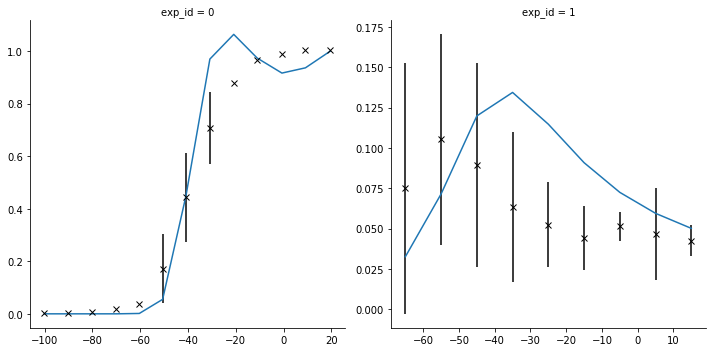

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     #sakakibara_inact,
                     #sakakibara_inact_kin_1,
                     #sakakibara_inact_kin_100,
                     #sakakibara_inact_kin_80,
                     #sakakibara_rec,
                     schneider_taum)

In [9]:
limits = {'ina.a1_m': (-100, 0),
          'ina.a2_m': (0, 1),
          'ina.a3_m': (0, 1),
          'ina.a4_m': (0, 10),
          'ina.b1_m': (0, 10),
          'ina.b2_m': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_mgate_reported.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5570757359362264, '1': 1.5570757359362264, '2': 1.5570757359362264, '3': 1.5570757359362264, '4': 1.5570757359362264, '5': 0.5904911622959486, '6': 0.45939980914873735, '7': 0.5710013425594168, '8': 1.5570757359362264, '9': 1.5570757359362264, '10': 1.5570757359362264, '11': 1.5570757359362264, '12': 1.5570757359362264, '13': 0.15235445469736852, '14': 0.1819349064747563, '15': 0.1879980741832115, '16': 0.25507625823484376, '17': 0.4491978085688121, '18': 0.5936989296806218, '19': 1.3185718986681156, '20': 0.4160669679218102, '21': 1.2534510282040947}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-23 17:07:35.760566, end_time=None)>


In [17]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 996
DEBUG:Epsilon:new eps, t=1, eps=1.0311347633808372
INFO:ABC:t:1 eps:1.0311347633808372
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 2026
DEBUG:Epsilon:new eps, t=2, eps=0.7597488221321739
INFO:ABC:t:2 eps:0.7597488221321739
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 3194
DEBUG:Epsilon:new eps, t=3, eps=0.6487851633963204
INFO:ABC:t:3 eps:0.6487851633963204
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 4462
DEBUG:Epsilon:new eps, t=4, eps=0.5598610116739912
INFO:ABC:t:4 eps:0.5598610116739912
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 5809
DEBUG:Epsilon:new eps, t=5, eps=0.49570040317337

### Database results analysis

In [19]:
history = History(db_path)

In [20]:
df, w = history.get_distribution(m=0)

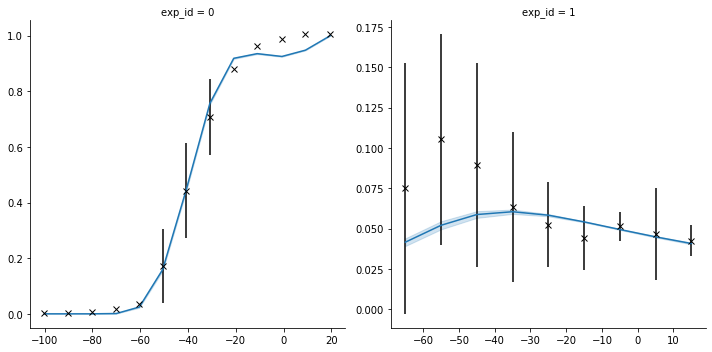

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     #sakakibara_inact,
                     #sakakibara_inact_kin_1,
                     #sakakibara_inact_kin_100,
                     #sakakibara_rec100,
                     schneider_taum,
                     df=df, w=w)

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

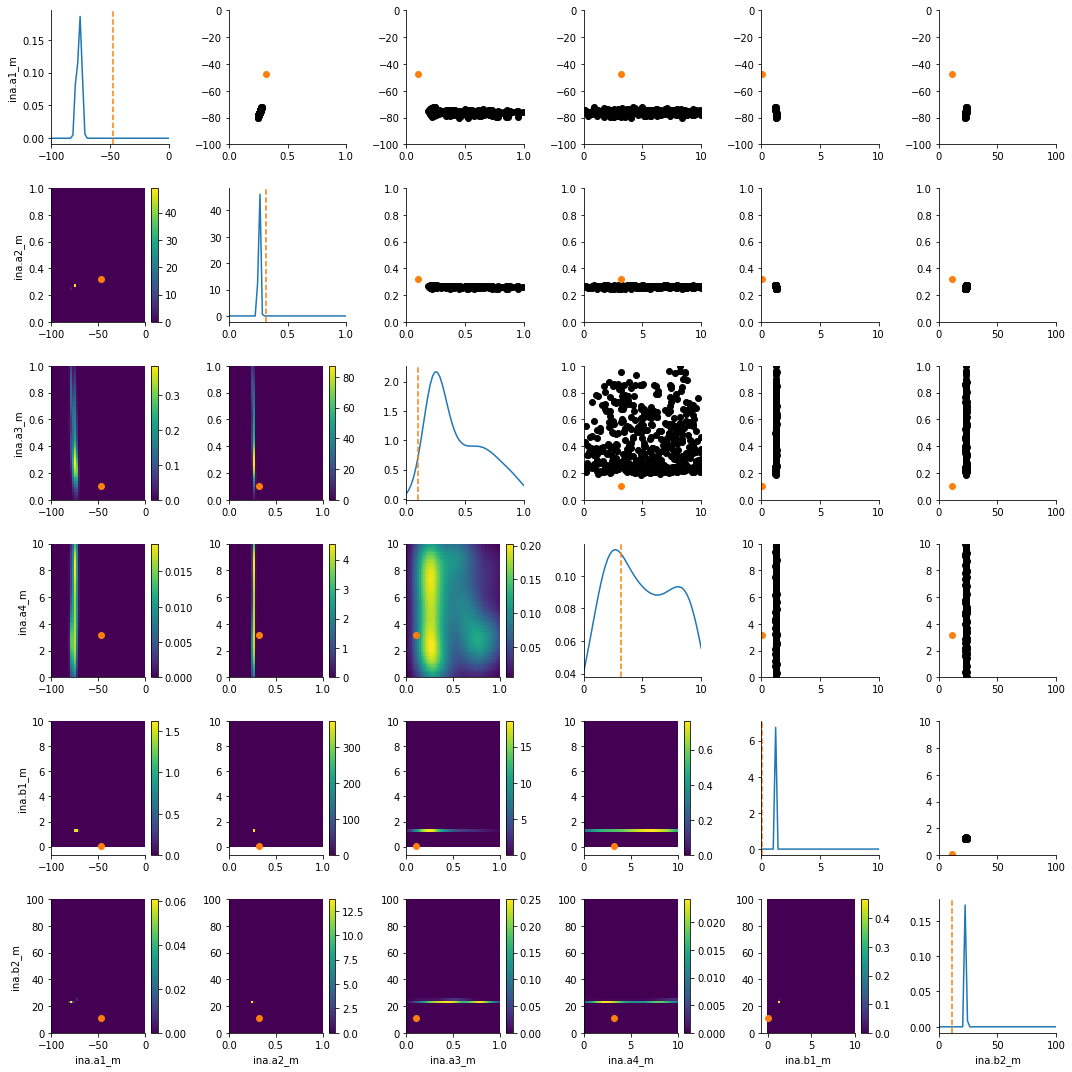

In [25]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# H gate -> Only SS inactivation and tau_h

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_fast,
                                                sakakibara_rec_fast)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

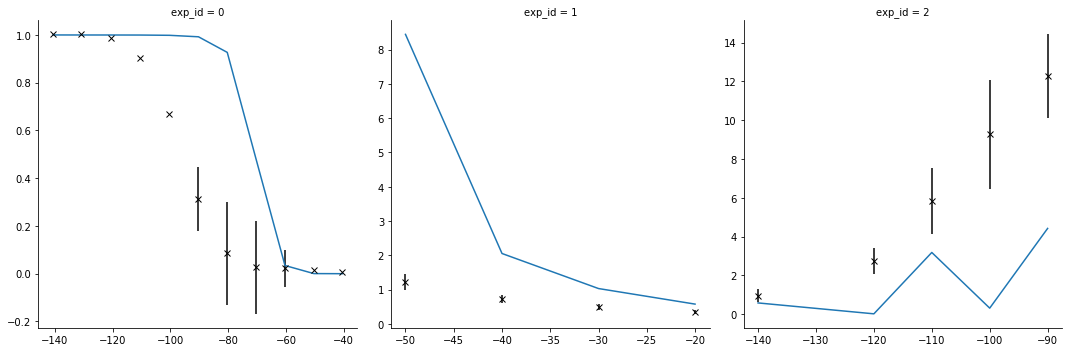

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast)

In [7]:
limits = {'ina.c1_h': (-100, 0),
          'ina.a1_h': (0, 10),
          'ina.a2_h': (0, 50),
          'ina.a3_h': (0, 100),
          #'ina.b1_h': (0, 1),
          'ina.b2_h': (0, 100),
          'ina.b3_h': (0, 50),
          'log_ina.b4_h': (-1, 2),
          'log_ina.b5_h': (-3, 0),
          'log_ina.b6_h': (3, 6),
          'log_ina.b7_h': (-2, 0)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [6]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_hgate_reported.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9298311489289642, '1': 0.9298311489289642, '2': 0.9298311489289642, '3': 0.9298311489289642, '4': 0.9298311489289642, '5': 0.34877521029031383, '6': 0.21674341481487852, '7': 0.24006575158114657, '8': 0.5989135286482826, '9': 0.9298311489289642, '10': 0.9298311489289642, '11': 0.6679914857297752, '12': 1.3151082375304948, '13': 1.8297158087380803, '14': 2.5570356595546513, '15': 2.0456285276437214, '16': 1.901285628941935, '17': 0.7393593039114589, '18': 0.44622757416898995, '19': 0.5843318259435246}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-24 18:10:55.196815, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.005)

INFO:ABC:t:15 eps:0.5038633058529319
DEBUG:ABC:now submitting population 15


### Database results analysis

In [8]:
history = History(db_path)

In [9]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-09-24 18:10:55.196815, end_time=2019-09-25 05:00:49.313710)>]

In [10]:
df, w = history.get_distribution(m=0)

In [11]:
df.describe()

name,ina.a1_h,ina.a2_h,ina.a3_h,ina.b2_h,ina.b3_h,ina.c1_h,log_ina.b4_h,log_ina.b5_h,log_ina.b6_h,log_ina.b7_h
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.711967,15.330925,85.973949,30.651407,21.150606,-39.716674,0.345346,-2.145128,4.407611,-0.383970
std,2.218361,10.508455,12.960464,22.608307,10.251624,15.739760,0.419667,0.540421,0.789562,0.181648
min,0.009170,1.045572,31.831473,0.143932,0.591621,-96.145536,-0.852251,-2.995651,3.000515,-0.923851
25%,1.047546,7.858017,82.014849,14.169091,13.878965,-50.101245,0.101694,-2.581632,3.744273,-0.519837
50%,2.236388,12.431727,89.740363,25.940630,18.737894,-41.745758,0.248659,-2.247714,4.424346,-0.403090
75%,3.838251,19.347479,95.069205,39.988075,26.385916,-29.328005,0.465567,-1.727928,5.032498,-0.242899
max,9.922091,49.430819,99.986344,99.964395,49.541832,-0.059193,1.853424,-1.076346,5.981937,-0.000124


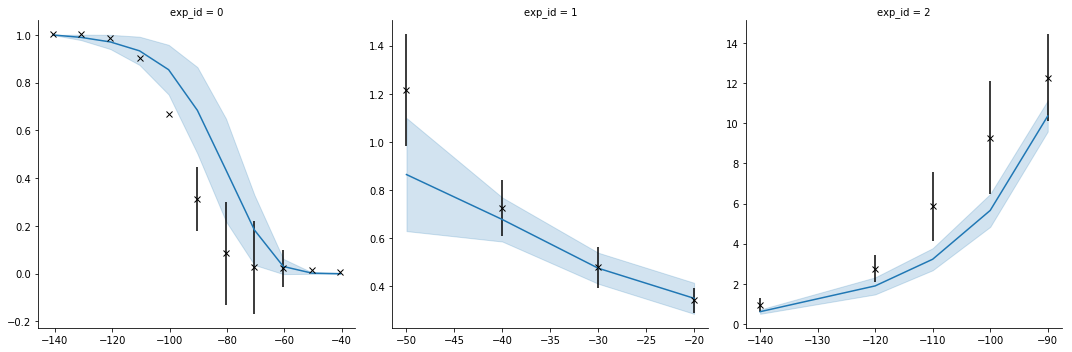

In [22]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=df, w=w)

In [12]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [13]:
m,_,_ = myokit.load(modelfile)

In [14]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

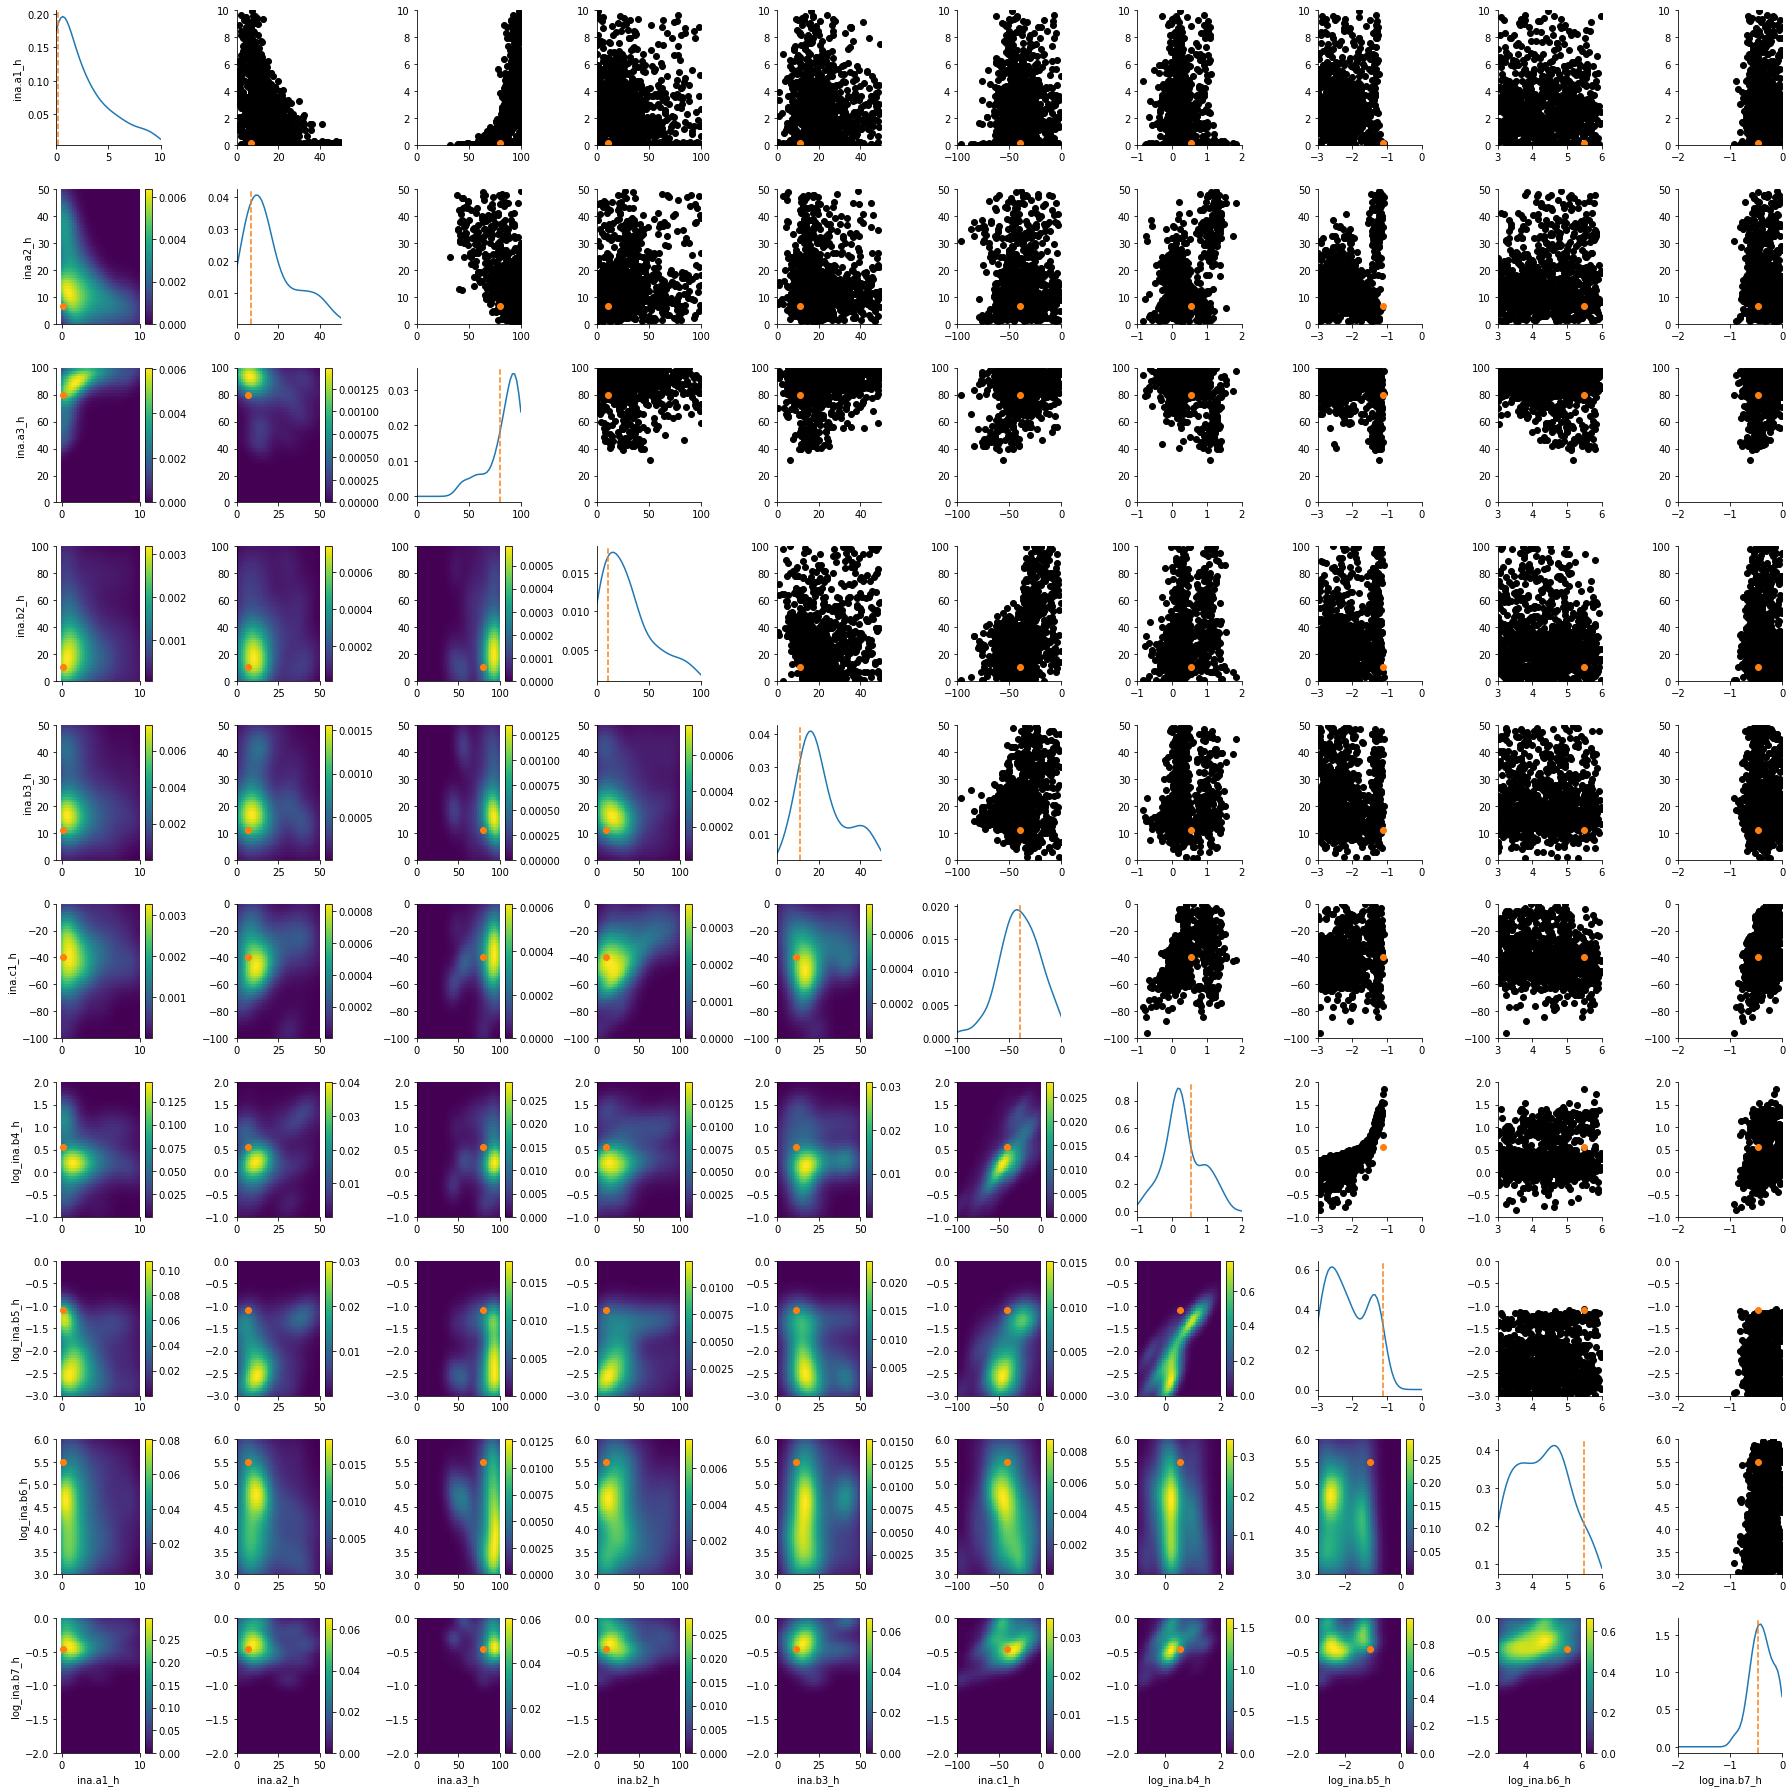

In [15]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# J gate -> Only SS inactivation and tau_j

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_slow,
                                                sakakibara_rec_slow)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow)

TypeError: list indices must be integers or slices, not float

In [6]:
limits = {'ina.c1_j': (-100, 0),
          'log_ina.a1_j': (4, 7),
          'log_ina.a2_j': (-2, 1),
          'log_ina.a3_j': (-6, -4),
          'log_ina.a4_j': (-3, -1),
          'ina.a5_j': (0, 100),
          'ina.a6_j': (0, 1),
          'ina.a7_j': (0, 100),
          #'ina.b1_j': (0, 1),
          'log_ina.b2_j': (-8, -6),
          'ina.b3_j': (0, 1),
          'ina.b4_j': (0, 100),
          'log_ina.b5_j': (-2, 1),
          'log_ina.b6_j': (-3, -1),
          'ina.b7_j': (0, 1),
          'ina.b8_j': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [7]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_jgate_reported.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9818869939747233, '1': 0.9818869939747233, '2': 0.9818869939747233, '3': 0.9818869939747233, '4': 0.9818869939747233, '5': 0.3683011084316996, '6': 0.2288776196425918, '7': 0.25350563857514163, '8': 0.6324432182903594, '9': 0.9818869939747233, '10': 0.9818869939747233, '11': 2.700189233430489, '12': 0.4957538129507886, '13': 1.412898366909747, '14': 2.700189233430489, '15': 2.160151386744391, '16': 0.7192132991083816, '17': 0.7852456348032116, '18': 0.3846095367327172, '19': 0.2854129531269287}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-07 12:09:46.086282, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [13]:
abc_cont = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9818869939747233, '1': 0.9818869939747233, '2': 0.9818869939747233, '3': 0.9818869939747233, '4': 0.9818869939747233, '5': 0.3683011084316996, '6': 0.2288776196425918, '7': 0.25350563857514163, '8': 0.6324432182903594, '9': 0.9818869939747233, '10': 0.9818869939747233, '11': 2.700189233430489, '12': 0.4957538129507886, '13': 1.412898366909747, '14': 2.700189233430489, '15': 2.160151386744391, '16': 0.7192132991083816, '17': 0.7852456348032116, '18': 0.3846095367327172, '19': 0.2854129531269287}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [16]:
abc_cont.load(db_path, 1)

1

In [ ]:
history = abc_cont.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:Epsilon:initial epsilon is 0.47160723268232435
INFO:ABC:t:22 eps:0.47160723268232435
DEBUG:ABC:now submitting population 22


### Database results analysis

In [8]:
history = History(db_path)

In [9]:
df, w = history.get_distribution(m=0)

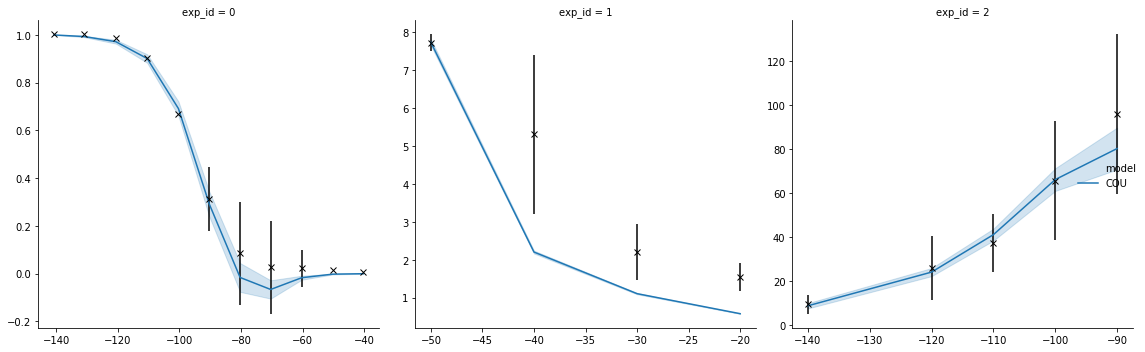

In [10]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow,
                     df=df, w=w)

In [11]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [12]:
m,_,_ = myokit.load(modelfile)

In [13]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

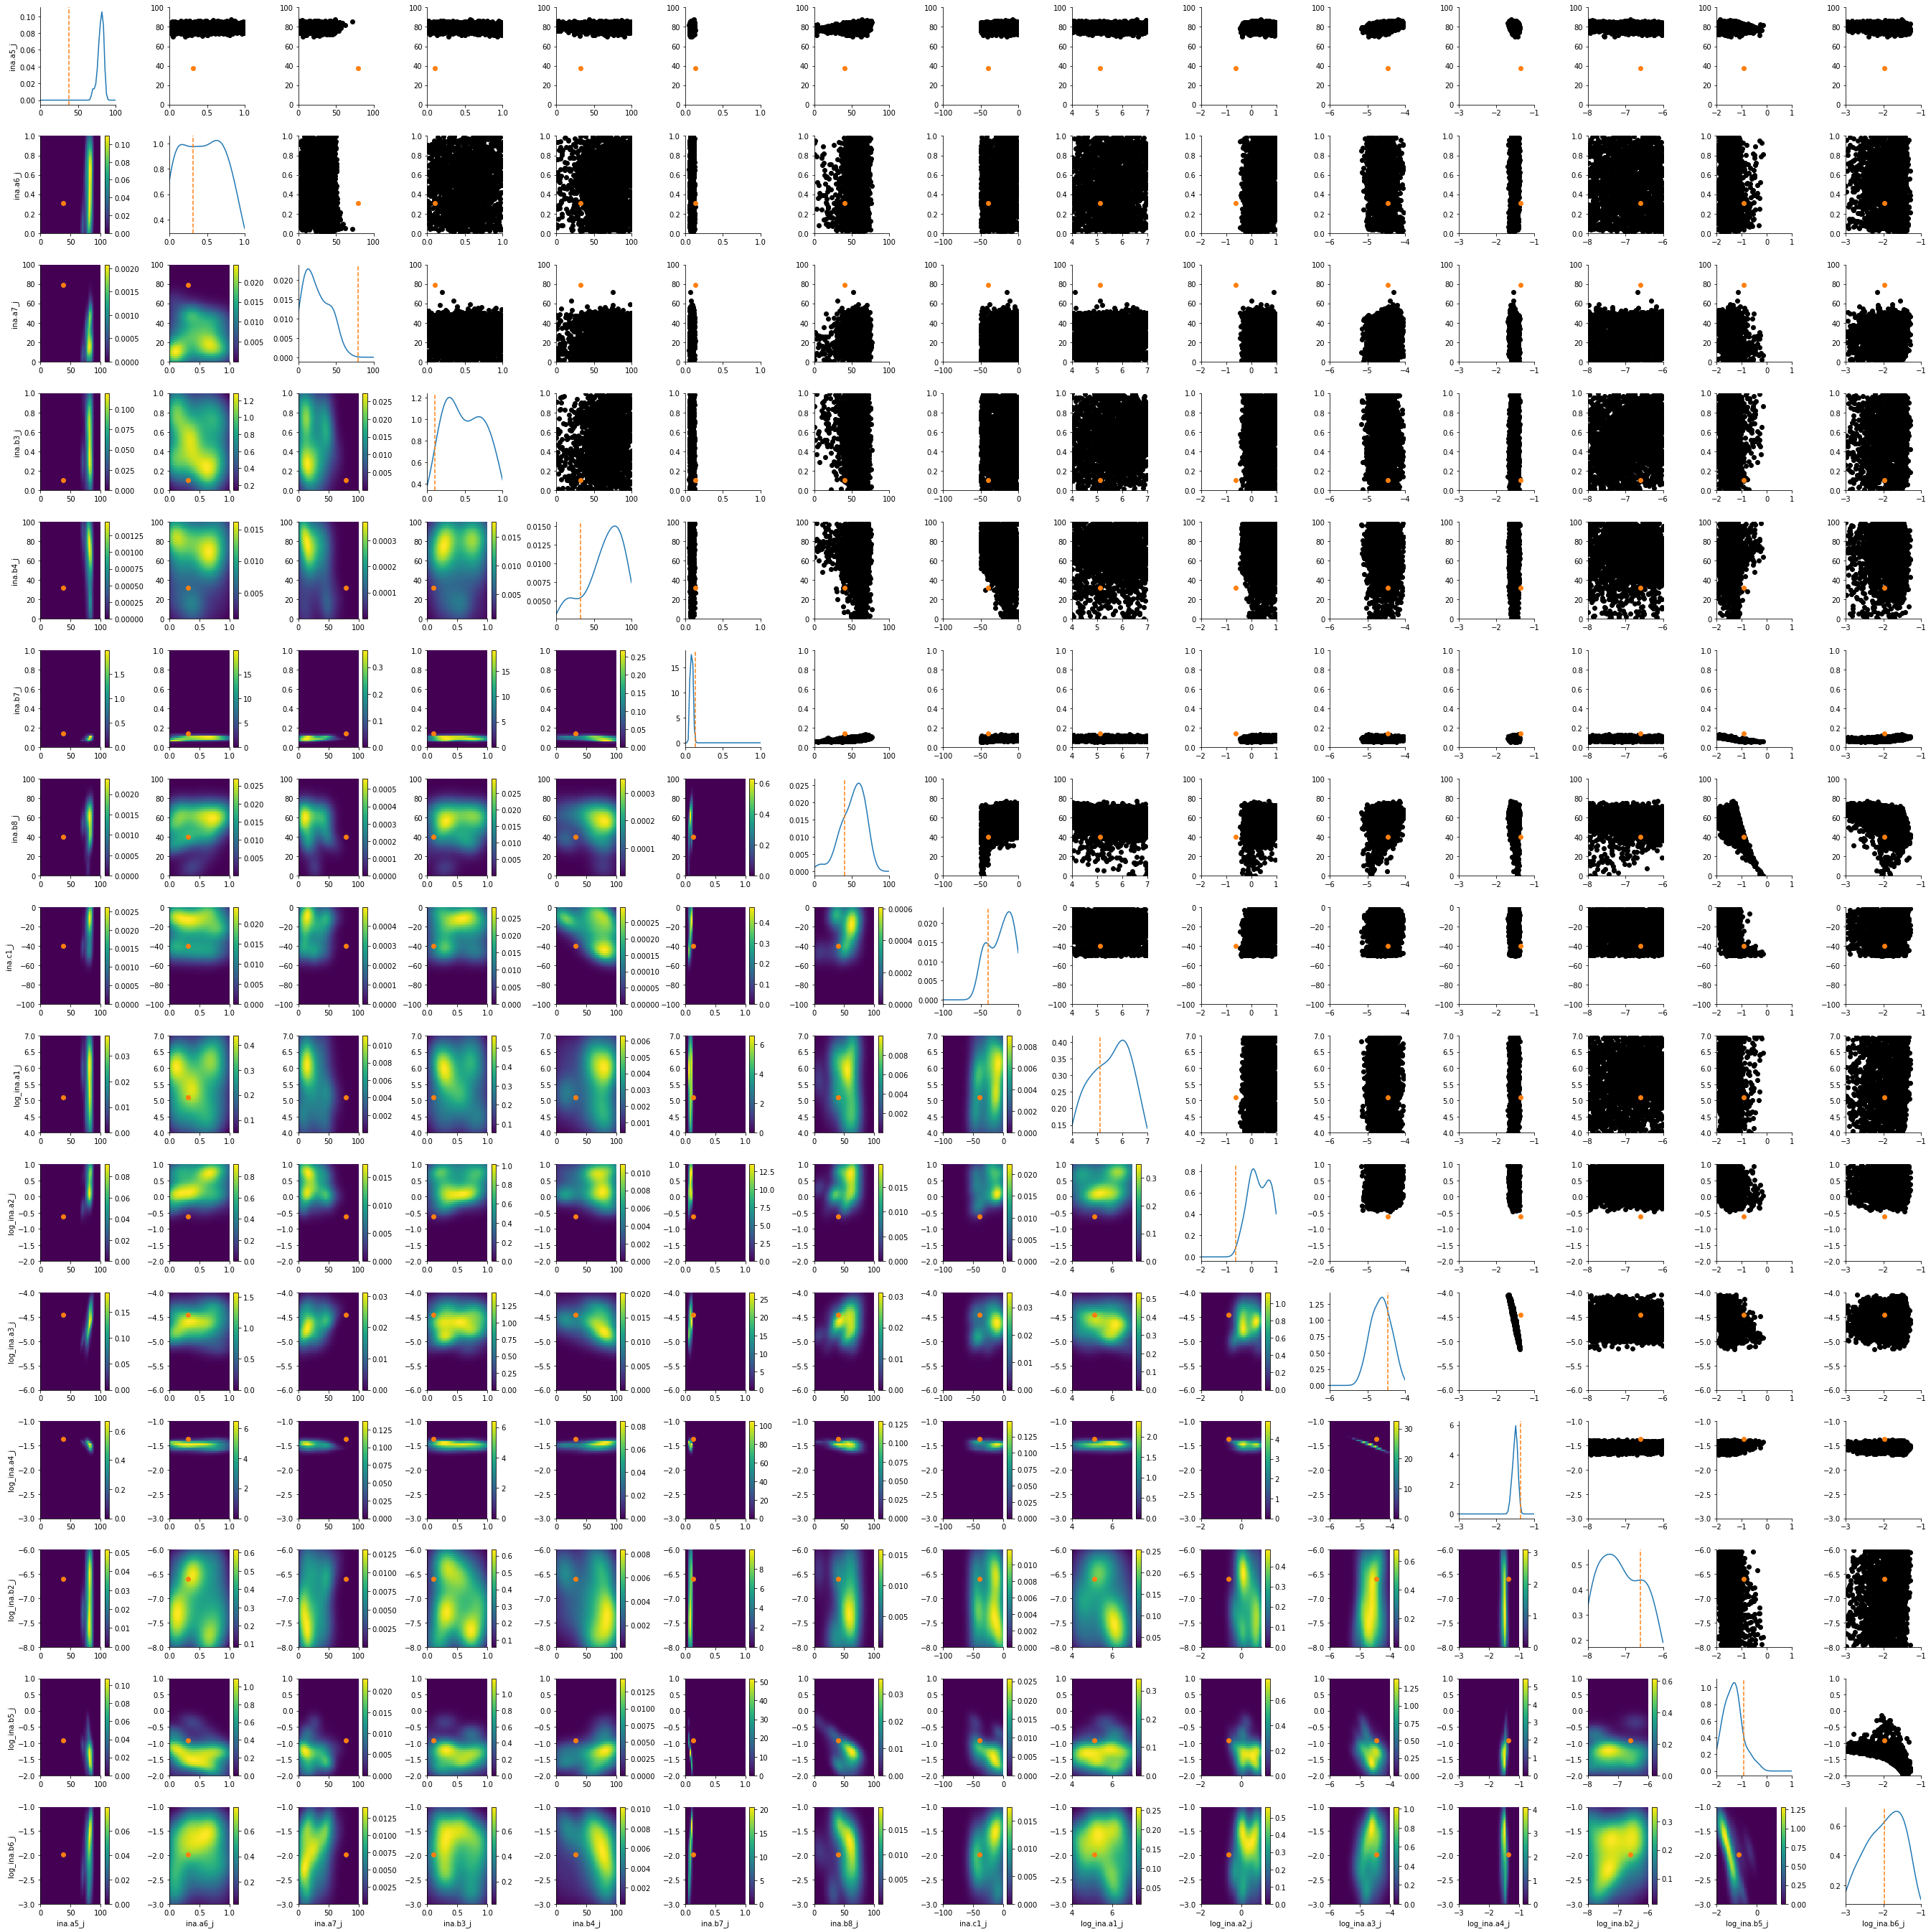

In [14]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)